<div class="title">Aplicaciones de Análisis &ndash; Keras</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Configuración inicial**

In [ ]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
%load_ext tensorboard

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow import keras

import gym

matplotlib.rc("figure", figsize=(15, 5))
matplotlib.rc("image", cmap="cividis")

seed = 1234

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Primeros pasos

* Keras es una API de alto nivel que facilita las aplicaciones de ML.
* En la práctica, muchas veces no hay necesidad de acceder directamente a TensorFlow.

## Introducción a Keras

### Repaso de Redes Neuronales Artificiales

* Las Redes Neuronales Artificiales (ANN) son modelos bioinspirados.

<img src="figures/Neuron.svg?10" alt="Neuron.">

* La unidad elemental es el perceptrón, o TLU.

<img src="figures/TLU.svg?10" alt="TLU.">

### Ejemplo: el perceptrón para regresión

* Aunque tiene otros *backends*, Keras se puede importar como parte de TensorFlow.

In [3]:
from tensorflow import keras

* Keras permite crear un modelo, equivalente al perceptrón de regresión (un modelo lineal) de forma sencilla, con métodos `fit` y `predict` asociados.

In [47]:
model = keras.Sequential([keras.layers.Dense(units=1,
                                             activation="linear",
                                             input_shape=(1,),
                                             name="TLU")])
model.compile(loss="mean_squared_error")

keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<div class="qst">

* Entrenar el perceptrón sobre el conjunto de datos (`x_tr`, `y_tr`) usado anteriormente.

</div>

In [48]:
x_tr = tf.cast(tf.linspace(-1, 1, 101), dtype=tf.float32)
y_tr = x_tr * 2 + 5

################################
# Insertar código.
model.fit(x_tr, y_tr, epochs=5)
################################

Epoch 1/5
4/4 [==============================] - 0s 5ms/step - loss: 27.9618
Epoch 2/5
4/4 [==============================] - 0s 5ms/step - loss: 27.8704
Epoch 3/5
4/4 [==============================] - 0s 5ms/step - loss: 27.8089
Epoch 4/5
4/4 [==============================] - 0s 5ms/step - loss: 27.7610
Epoch 5/5
4/4 [==============================] - 0s 5ms/step - loss: 27.7165


Optimal weights: [array([[-0.9495723]], dtype=float32), array([0.02807434], dtype=float32)]
4/4 [==============================] - 0s 2ms/step


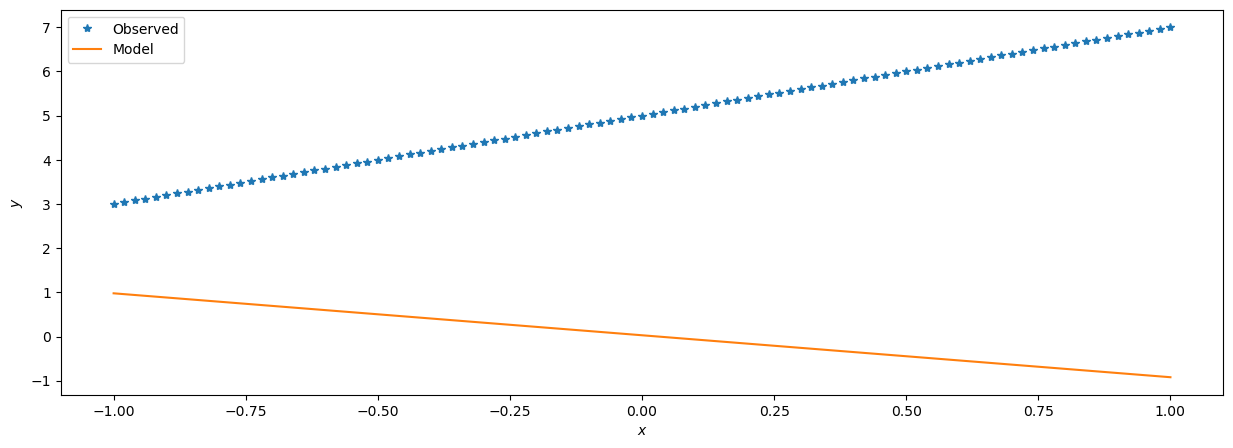

In [49]:
print("Optimal weights:", model.get_weights())

plt.plot(x_tr.numpy(), y_tr.numpy(), "*", label="Observed")
plt.plot(x_tr.numpy(), model.predict(x_tr), "-", label="Model")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

## Capas

### Introducción a las capas

* Tradicionalmente, las ANN se organiza en capas de unidades.
    * La salida de las neuronas de una capa se usa como entrada de la capa siguiente.

<img src="figures/MLP.svg?15" alt="MLP clásico.">

* En el contexto de TensorFlow, las capas se generalizan a funciones con una cierta estructura matemática conocida, que se pueden reutilizar y que tienen variables que pueden ser entrenadas.
* Intuitivamente, se pueden considerar como las piezas fundamentales de un modelo de ML.
    * Realizan una cierta transformación desde los datos de entrada a los datos de salida.
    * Esta transformación se puede adaptar a los datos durante el entrenamiento.

### Principales tipos de capas

* En Keras existen diversos tipos de capas:
    * Capas básicas.
    * Capa de convolución.
    * Capas de *pooling*.
    * Capas recurrentes.
    * Capas de preproceso.
    * Capas de normalización.
    * Capas de regularización.
    * Capas de cambio de forma.
    * Capas de combinación.
* En la siguiente tabla se muestran algunas de las principales capas básicas:

| Tipo de Capa | Clase | Descripción                                                                          |
|:-------------------|:------------------------|:-------------------------------------------------------------|
| Capa de entrada    | `keras.Input`           | Capa que tomará  los valores de la entrada.                  |
| Capa densa         | `keras.layers.Dense`    | Capa completamente conectada.                                |
| Capa de activación| `keras.layers.Activation`| Capa para aplicar la función de activación a la salida de la capa anterior.|
| Capa de *embedding*| `keras.layers.Embedding`| Capa para codificar valores discretos en un espacio continuo.|
| Capa lambda     | `keras.layers.Lambda`     | Capa para aplicar una función arbitraria de TensorFlow.        |

* Las capas no son más que funciones de TensorFlow, que se pueden aplicar a tensores que tengan las dimensiones apropiadas.

In [50]:
layer = keras.layers.Dense(3, input_shape=(3,))
print(layer(tf.constant([[1, 1, 1]])).numpy())

[[-1.2146635   0.53489614  0.24984074]]


<div class="info"><a href="https://keras.io/api/layers/">Capas de Keras</a></div>

## Modelo secuencial

* Los modelos secuenciales de Keras están concebidos como una pila de capas, donde cada capa toma como entrada un tensor, y produce como salida otro tensor.
* Al crear el modelo secuencial, se especifica una lista de las capas que compondrán el modelo.
* El modelo completo actúa como una función de TensorFlow.

In [51]:
x = tf.ones((3, 3))

model = keras.Sequential(
    [
        keras.layers.Dense(2, activation="relu", name="layer1"),
        keras.layers.Dense(3, activation="relu", name="layer2"),
        keras.layers.Dense(4, name="layer3"),
    ]
)

print(model(x))

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(3, 4), dtype=float32)


* El modelo secuencial simplemente indica que cada capa se aplica sobre la salida de la anterior.

In [52]:
layer1 = keras.layers.Dense(2, activation="relu", name="layer1")
layer2 = keras.layers.Dense(3, activation="relu", name="layer2")
layer3 = keras.layers.Dense(4, name="layer3")

print(layer3(layer2(layer1(x))))

tf.Tensor(
[[-1.0959823  -0.03442053  0.9781779  -1.171892  ]
 [-1.0959823  -0.03442053  0.9781779  -1.171892  ]
 [-1.0959823  -0.03442053  0.9781779  -1.171892  ]], shape=(3, 4), dtype=float32)


* El modelo tiene un atributo `layers` con las capas que lo componen.

In [53]:
for l in model.layers:
    print(l)

* Se puede extraer un resumen del modelo, que muestra información útil como los parámetros entrenables que tiene.
* También se puede representar en forma de grafo.

In [54]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (3, 2)                    8         
                                                                 
 layer2 (Dense)              (3, 3)                    9         
                                                                 
 layer3 (Dense)              (3, 4)                    16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


* El modelo secuencial también se puede definir de forma incremental, añadiendo las capas sucesivamente.

In [55]:
model = keras.Sequential()
model.add(keras.layers.Dense(2, activation="relu"))
model.add(keras.layers.Dense(3, activation="relu"))
model.add(keras.layers.Dense(4))

print(model(x))

tf.Tensor(
[[-0.7282227   1.0335956  -1.1502393   0.91561896]
 [-0.7282227   1.0335956  -1.1502393   0.91561896]
 [-0.7282227   1.0335956  -1.1502393   0.91561896]], shape=(3, 4), dtype=float32)


* Por lo general, al crear una capa los pesos no se inicializan.
* La primera vez que se aplica la capa se crean los pesos, con la dimensión adecuada para esa entrada.

In [15]:
layer = keras.layers.Dense(3)
print("Weights (before using the layer):", layer.weights)

y = layer(x)
print("Weights (after using the layer): ", layer.weights)

Weights (before using the layer): []
Weights (after using the layer):  [<tf.Variable 'dense_4/kernel:0' shape=(3, 3) dtype=float32, numpy=
array([[ 0.1935134 , -0.43904614,  0.343781  ],
       [-0.65495014, -0.12996936, -0.3023646 ],
       [-0.9573791 , -0.7080059 , -0.38838863]], dtype=float32)>, <tf.Variable 'dense_4/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


* En el caso de modelos secuenciales, ocurre algo similar: los pesos no se inicializan hasta que no se aplica el modelo.

In [56]:
model = keras.Sequential(
    [
        keras.layers.Dense(2),
        keras.layers.Dense(3),
        keras.layers.Dense(4),
    ]
)
try:
    model.summary()
except Exception as e:
    print("Exception:", e)

print("\nApplying the model...")
model(x)

model.summary()

Exception: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Applying the model...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (3, 2)                    8         
                                                                 
 dense_55 (Dense)            (3, 3)                    9         
                                                                 
 dense_56 (Dense)            (3, 4)                    16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


* Sin embargo, se puede forzar a que se creen especificando la dimensión inicial con una capa de entrada.

In [57]:
model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(2),
        keras.layers.Dense(3),
        keras.layers.Dense(4),
    ]
)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 2)                 8         
                                                                 
 dense_58 (Dense)            (None, 3)                 9         
                                                                 
 dense_59 (Dense)            (None, 4)                 16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


* También se puede especificar el tamaño de la entrada como un parámetro de la primera capa.

In [58]:
model = keras.Sequential(
    [
        keras.layers.Dense(2, input_shape=(3,)),
        keras.layers.Dense(3),
        keras.layers.Dense(4),
    ]
)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 2)                 8         
                                                                 
 dense_61 (Dense)            (None, 3)                 9         
                                                                 
 dense_62 (Dense)            (None, 4)                 16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


<div class="qst">

* Definir una red neuronal con $5$ capas densas de $10$ neuronas cada una, para un problema de $20$ dimensiones de entrada y $1$ salida.
La función de activación será la sigmoidal para las capas ocultas, y la lineal para la capa de salida.
* Observar el número de parámetros entrenables, y comprobar que concuerda con el teórico.

</div>

In [59]:
################################
# Insertar código.

model = keras.Sequential(
    [
        keras.layers.Dense(10, input_shape=(20,)),
        keras.layers.Dense(10),
        keras.layers.Dense(10),
        keras.layers.Dense(10),
        keras.layers.Dense(10),
        keras.layers.Dense(1)
    ]
)

################################

print("\nTotal parameters (theor.):", (20 + 1) * 10 + 4 * ((10 + 1) * 10) + (10 + 1) * 1)


Total parameters (theor.): 661


## Modelo funcional

* Los modelos funcionales son más flexibles que los secuenciales.
    * Capas compartidas.
    * Múltiples entradas/salidas.
    * Cualquier topología de conexión.
* El modelo se define aplicando las capas como funciones, y especificando al final cuál será la entrada del modelo y cuál la salida.

In [60]:
inputs = keras.Input(shape=(3,))
x = keras.layers.Dense(2)(inputs)
x = keras.layers.Dense(3)(x)
outputs = keras.layers.Dense(4)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_69 (Dense)            (None, 2)                 8         
                                                                 
 dense_70 (Dense)            (None, 3)                 9         
                                                                 
 dense_71 (Dense)            (None, 4)                 16        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<div class="qst">

* Definir la red neuronal del ejercicio anterior usando la definición funcional.

</div>

In [61]:

################################
# Insertar código.

inputs = keras.Input(shape=(20,))
x = keras.layers.Dense(10)(inputs)
x = keras.layers.Dense(10)(x)
x = keras.layers.Dense(10)(x)
x = keras.layers.Dense(10)(x)
x = keras.layers.Dense(10)(x)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

keras.utils.plot_model(model, show_shapes=True)
################################

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 20)]              0         
                                                                 
 dense_72 (Dense)            (None, 10)                210       
                                                                 
 dense_73 (Dense)            (None, 10)                110       
                                                                 
 dense_74 (Dense)            (None, 10)                110       
                                                                 
 dense_75 (Dense)            (None, 10)                110       
                                                                 
 dense_76 (Dense)            (None, 10)                110       
                                                                 
 dense_77 (Dense)            (None, 1)                 11 

## Entrenamiento y predicción

Para ilustrar la creación, entrenamiento y predicción con un modelo de Keras, se usará el conjunto de datos de MNIST, accesible directamente desde Keras.

In [62]:
(x_tr, y_tr), (x_te, y_te) = keras.datasets.mnist.load_data()

x_tr = x_tr.reshape(60000, 784).astype("float32") / 255
x_te = x_te.reshape(10000, 784).astype("float32") / 255

y_tr = y_tr.astype("float32")
y_te = y_te.astype("float32")

### Definición del modelo

* El primer paso es crear el modelo (puede ser tanto secuencial como funcional).

In [63]:
model = keras.Sequential(
    [
        keras.Input(shape=(784,), name="digits"),
        keras.layers.Dense(64, activation="relu", name="dense_1"),
        keras.layers.Dense(64, activation="relu", name="dense_2"),
        keras.layers.Dense(10, activation="softmax", name="predictions"),
    ]
)

keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<div class="qst">

* Definir un modelo lineal de clasificación binaria, de nombre `perceptron`, para un problema de $2$ dimensiones.
Usar la aproximación funcional.

</div>

In [64]:
################################
# Insertar código.

inputs = keras.Input(shape=(2,))
x = keras.layers.Dense(4, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(4, activation="relu", name="dense_2")(x)
outputs = keras.layers.Dense(1, activation="softmax", name="predictions")(x)

perceptron = keras.Model(inputs=inputs, outputs=outputs)
perceptron.summary()

keras.utils.plot_model(perceptron, show_shapes=True)

################################

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 12        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 predictions (Dense)         (None, 1)                 5         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Compilación

* Una vez creado el modelo, hay que compilarlo, especificando:
    * La función de pérdida, que se minimizará durante el entrenamiento.
    * El optimizador, es decir, el algoritmo que se usará para minimizar la pérdida.
    * Las métricas con las que se evaluará el modelo para mostrar la evolución del entrenamiento.
* Existen diversas opciones para cada uno.
* Se pueden definir también nuevas pérdidas y métricas.

|Pérdida|Descripción   |Uso|
|:--|:--|:--|
|`mean_squared_error`  |Función estándar para problemas de regresión.     |Regresión|
|`mean_squared_logarithmic_error`|Similar a la anterior, pero al ser logarítmica "suaviza el castigo".       |Regresión    |
|`mean_absolute_error`|Apropiada cuando la distribución de datos tiene valores grandes o pequeños muy alejados del valor medio.|Regresión                           |
|`binary_crossentropy` |Adecuada para problemas de clasificación binaria con valores $0$ y $1$.|Clasificación|
|`hinge`|Pérdida de la SVM.|Clasificación|
|`squared_hinge`|Suaviza la función de error anterior y resulta más sencilla en cómputo.|Clasificación|
|`categorical_crossentropy`|Función de pérdida utilizado por defecto para problemas de clasificación múltiple (*hot-enconding*).|Clasificación |
|`sparse_categorical_crossentropy`|Función de pérdida para problemas de clasificación múltiple (valores enteros).|Clasificación|

|Optimizador|Velocidad|Calidad|
|:--|:--|:--|
|SGD|Baja|Alta|
|Adagrad|Media|Alta|
|RMSprop|Alta|Media-Alta|
|Adam|Alta|Media o Alta|
|Nadam|Alta|Media o Alta|
|AdaMax|Alta|Media o Alta|

In [65]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),                # Equivalently, "rmsprop".
    loss=keras.losses.SparseCategoricalCrossentropy(),   # Equivalently, "sparse_categorical_crossentropy".
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

<div class="qst">

* Compilar el modelo `perceptron` para minimizar la entropía binaria, usando ADAM, y monitorizando la precisión (*accuracy*).

</div>

In [66]:
################################
# Insertar código.
perceptron.compile(
    optimizer=keras.optimizers.Adam(),               
    loss=keras.losses.BinaryCrossentropy(),   
    metrics=[keras.metrics.Accuracy()],
)
################################

<div class="info"><a href="https://keras.io/api/losses/">Pérdidas de Keras</a></div><br>
<div class="info"><a href="https://keras.io/api/optimizers/">Optimizadores de Keras</a></div><br>
<div class="info"><a href="https://keras.io/api/metrics/">Métricas de Keras</a></div>

### Entrenamiento

* Tras compilar el modelo, se puede entrenar usando el método `fit`.

In [67]:
print("Fit model on training data")
history = model.fit(
    x_tr,
    y_tr,
    batch_size=64,
    epochs=5,
    validation_split=0.3,
)

Fit model on training data
Epoch 1/5
657/657 [==============================] - 5s 7ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.2176 - val_sparse_categorical_accuracy: 0.9363
Epoch 2/5
657/657 [==============================] - 5s 7ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1749 - val_sparse_categorical_accuracy: 0.9479
Epoch 3/5
657/657 [==============================] - 5s 7ms/step - loss: 0.1222 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9587
Epoch 4/5
657/657 [==============================] - 5s 7ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.1225 - val_sparse_categorical_accuracy: 0.9641
Epoch 5/5
657/657 [==============================] - 5s 7ms/step - loss: 0.0806 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.1355 - val_sparse_categorical_accuracy: 0.9617


In [68]:
print(history.history)

{'loss': [0.37059780955314636, 0.16983765363693237, 0.12218904495239258, 0.09679841250181198, 0.08057799190282822], 'sparse_categorical_accuracy': [0.8954761624336243, 0.9509047865867615, 0.9634761810302734, 0.9714523553848267, 0.9753333330154419], 'val_loss': [0.21756500005722046, 0.17485468089580536, 0.13928306102752686, 0.12245287001132965, 0.1355191171169281], 'val_sparse_categorical_accuracy': [0.9362778067588806, 0.9479444622993469, 0.9586666822433472, 0.9640555381774902, 0.961722195148468]}


<div class="qst">

* Entrenar el modelo `perceptron` sobre el conjunto de datos definido a continuación.
* Razonar si el modelo entrenado será capaz de resolver este problema o no.

</div>

In [69]:
x_pcp = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_pcp = np.array([0, 1, 1, 0])

################################
# Insertar código.
print("Fit model on training data")
history = perceptron.fit(
    x_pcp,
    y_pcp,
    batch_size=64,
    epochs=5,
    validation_split=0.3,
)
################################

Fit model on training data
Epoch 1/5
1/1 [==============================] - 1s 743ms/step - loss: 0.8092 - accuracy: 0.5000 - val_loss: 0.6415 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 33ms/step - loss: 0.8066 - accuracy: 0.5000 - val_loss: 0.6419 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 33ms/step - loss: 0.8042 - accuracy: 0.5000 - val_loss: 0.6423 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 32ms/step - loss: 0.8017 - accuracy: 0.5000 - val_loss: 0.6428 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 33ms/step - loss: 0.7994 - accuracy: 0.5000 - val_loss: 0.6432 - val_accuracy: 0.5000


### Predicción

* Una vez entrenado, se puede predecir con el modelo mediante el método `predict`.

In [70]:
print("Test error, test accuracy:", model.evaluate(x_te, y_te))

pred = model.predict(x_te)
print(pred.shape)
print(pred[:10])

313/313 [==============================] - 1s 4ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9669
Test error, test accuracy: [0.11107058078050613, 0.9668999910354614]
313/313 [==============================] - 1s 2ms/step
(10000, 10)
[[2.33836133e-08 7.76505249e-10 1.25976885e-05 3.36427620e-05
  5.99105876e-10 2.47527225e-08 6.92279960e-14 9.99944210e-01
  2.91688931e-08 9.48269917e-06]
 [1.91266440e-06 6.69619534e-04 9.98633206e-01 6.89475157e-04
  1.11201109e-12 1.77632558e-07 3.11069819e-08 1.09060485e-08
  5.50865980e-06 9.74172965e-11]
 [2.83755944e-04 9.92297947e-01 6.81515550e-04 4.18649201e-04
  1.18148411e-04 6.55683034e-05 5.08941477e-04 3.85764381e-03
  1.62288931e-03 1.45005237e-04]
 [9.99924660e-01 4.84229590e-09 1.50215501e-05 1.31320633e-07
  2.95477474e-08 1.80316192e-07 5.35553445e-05 5.24266306e-06
  4.42124062e-08 1.20277707e-06]
 [1.68090046e-05 1.19892718e-06 1.46184437e-04 3.86731381e-06
  9.54215109e-01 5.09046891e-04 3.06049769e-05 1.18400014e-04
  5.

* El entrenamiento se puede realizar usando un `Dataset` de Keras, más eficiente y con opciones adicionales.

In [71]:
dataset_tr = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
dataset_tr = dataset_tr.shuffle(buffer_size=1024).batch(64)
print(dataset_tr)

model.fit(dataset_tr, epochs=3)
model.predict(x_te)

<BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
Epoch 1/3
938/938 [==============================] - 5s 6ms/step - loss: 0.0805 - sparse_categorical_accuracy: 0.9769
Epoch 2/3
938/938 [==============================] - 6s 6ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9800
Epoch 3/3
313/313 [==============================] - 1s 2ms/step


array([[1.2550730e-09, 1.9838011e-09, 3.3419610e-06, ..., 9.9999499e-01,
        2.5773508e-09, 1.4416470e-06],
       [2.8510215e-08, 1.2150059e-03, 9.9771535e-01, ..., 8.0235054e-09,
        2.1635449e-06, 5.7801770e-11],
       [6.1355458e-05, 9.9845946e-01, 3.5181968e-04, ..., 6.3395523e-04,
        1.7302661e-04, 5.2147931e-05],
       ...,
       [2.8014683e-14, 2.6560397e-12, 4.7520608e-14, ..., 9.4258903e-09,
        1.2344061e-07, 4.2950546e-06],
       [1.0022498e-11, 9.9949427e-10, 2.0285186e-12, ..., 2.9300187e-11,
        3.8214326e-05, 4.7115940e-11],
       [5.1498557e-09, 9.3318365e-13, 1.9091718e-11, ..., 2.6133133e-19,
        2.9525236e-12, 2.4826335e-13]], dtype=float32)

<div class="qst">

* Obtener las predicciones del modelo `perceptron` sobre el conjunto de entrenamiento `x_pcp`.
* Analizar el resultado obtenido.

</div>

In [ ]:
################################
# Insertar código.

################################

### Persistencia

* Se puede almacenar un modelo con el método `save`.

In [72]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


* Para cargarlo basta con usar `keras.models.load_model`.

In [73]:
loaded = keras.models.load_model("model")
loaded.predict(x_te)

313/313 [==============================] - 1s 2ms/step


array([[1.2550730e-09, 1.9838011e-09, 3.3419610e-06, ..., 9.9999499e-01,
        2.5773508e-09, 1.4416470e-06],
       [2.8510215e-08, 1.2150059e-03, 9.9771535e-01, ..., 8.0235054e-09,
        2.1635449e-06, 5.7801770e-11],
       [6.1355458e-05, 9.9845946e-01, 3.5181968e-04, ..., 6.3395523e-04,
        1.7302661e-04, 5.2147931e-05],
       ...,
       [2.8014683e-14, 2.6560397e-12, 4.7520608e-14, ..., 9.4258903e-09,
        1.2344061e-07, 4.2950546e-06],
       [1.0022498e-11, 9.9949427e-10, 2.0285186e-12, ..., 2.9300187e-11,
        3.8214326e-05, 4.7115940e-11],
       [5.1498557e-09, 9.3318365e-13, 1.9091718e-11, ..., 2.6133133e-19,
        2.9525236e-12, 2.4826335e-13]], dtype=float32)

<div class="qst">

* Almacenar el perceptrón en el archivo `"perceptron.h5"`.

</div>

In [ ]:
################################
# Insertar código.

################################

# Opciones avanzadas

* Para motivar algunas opciones de Keras, se utilizará el conjunto de datos Fashion MNIST.
* Este problema consiste en distinguir entre $10$ tipos distintos de ropa:

| Etiqueta| Descripción|
|:--|:--|
|0 |	T-shirt/top |
|1 |	Trouser |
|2 |	Pullover |
|3 |	Dress |
|4 |	Coat |
|5 |	Sandal |
|6 |	Shirt |
|7 |	Sneaker |
|8 |	Bag |
|9 |	Ankle boot |

4422102/4422102 [==============================] - 0s 0us/step
Training size: (60000, 28, 28)
Target size:   (60000,)
Maximum:       255
Minimum:       0


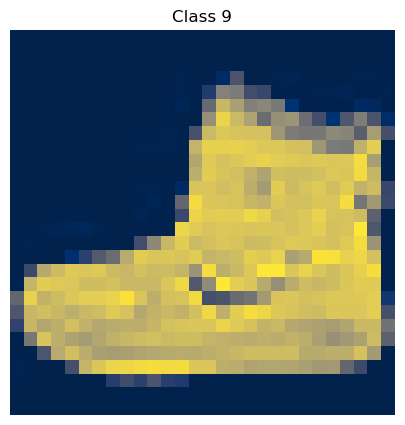

In [74]:
mnist = tf.keras.datasets.fashion_mnist

(x_tr, y_tr),(x_te, y_te) = mnist.load_data()
x_tr = x_tr
x_te = x_te

print("Training size:", x_tr.shape)
print("Target size:  ", y_tr.shape)
print("Maximum:      ", x_tr.max())
print("Minimum:      ", x_tr.min())

plt.imshow(x_tr[0])
plt.axis("off")
plt.title("Class {}".format(y_tr[0]))
plt.show()

## Cambios de forma

* Una gran cantidad de problemas de hoy en día tienen cierta estructura multidimensional.
    * Señales.
    * Imágenes.
    * Vídeos.
* Cuando se quieren procesar este tipo de datos con capas densas, es necesario "aplanarlos" mediante una capa `Flatten`, que los convierte en vectores.

A continuación se muestra una arquitectura para resolver el problema Fashion MNIST.

In [75]:
model = keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(10, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

model.summary()

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

history = model.fit(x_tr, y_tr, epochs=10)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_78 (Dense)            (None, 10)                7850      
                                                                 
 dense_79 (Dense)            (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 2.9054 - sparse_categorical_accuracy: 0.1736
Epoch 2/10
1875/1875 [==============================] - 8s 5ms/step - loss: 2.0349 - sparse_categorical_accuracy: 0.2008
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - los

<div class="qst">

* Comprobar si el resultado en test, calculado en la siguiente celda, es aceptable o no.
* Intentar mejorarlo sin modificar la arquitectura.

<div class="notes">

* A veces el problema no está en el modelo, sino en los datos.

</div>
</div>

In [76]:
test_loss, test_acc = model.evaluate(x_te, y_te)
print("Test accuracy:", test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.4559
Test accuracy: 0.45590001344680786


In [ ]:
################################
# Insertar código.

################################

## *Callbacks*

* Los *callbacks* son una herramienta para especificar el comportamiento del modelo durante el entrenamiento, la evaluación, o la predicción.
* Dos de los *callbacks* más importantes son:
    * `EarlyStopping`: Permite detener el entrenamiento cuando no se produce mejora (en función de la métrica seleccionada):
``` Python
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=0,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )
```
    * `ModelCheckpoint`: Guarda periódicamente el modelo durante el entrenamiento.
``` Python
    tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        options=None,
        **kwargs
    )
```
* Se pueden definir *callbacks* propios, heredando de la clase `Callback`, y definiendo uno o varios de los siguientes métodos:
| Método | Descripción |
|:--|:--|
|`on_(train\|test\|predict)_begin(self, logs=None)`| Invocada al empezar el entrenamiento/evaluación/predicción.|
|`on_(train\|test\|predict)_end(self, logs=None)`| Invocada al terminar el entrenamiento/evaluación/predicción.|
|`on_(train\|test\|predict)_batch_begin(self, batch, logs=None)`| Invocada al empezar a procesar un *batch* en entrenamiento/evaluación/predicción.|
|`on_(train\|test\|predict)_batch_end(self, batch, logs=None)`| Invocada al terminar de procesar un *batch* en entrenamiento/evaluación/predicción.|
|`on_epoch_begin(self, epoch, logs=None)`| Invocada al empezar una época de entrenamiento.|
|`on_epoch_end(self, epoch, logs=None)`| Invocada al terminar una época de entrenamiento.|

A continuación se define un *callback* para detener el entrenamiento si la pérdida en validación no mejora tras $3$ épocas, y otro para ir guardando el modelo (si mejora respecto al anterior).

In [77]:
early_stopping = keras.callbacks.EarlyStopping(patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("model", save_best_only=True)

Ahora se define un *callback* personalizado que detiene el entrenamiento si la precisión en entrenamiento supera el $60\%$.

In [78]:
# Stop the model when the training accuracy arrives to 0.60.
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (logs["sparse_categorical_accuracy"] > 0.6):
            print("Desired accuracy achieved")
            self.model.stop_training = True

my_stopping = MyCallback()

Por último, se entrena el modelo con los *callbacks* definidos.

In [79]:
history = model.fit(x_tr,
                    y_tr,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[early_stopping, checkpoint, my_stopping])

Epoch 1/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1514 - sparse_categorical_accuracy: 0.4933 - val_loss: 1.1436 - val_sparse_categorical_accuracy: 0.5090
Epoch 2/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1471 - sparse_categorical_accuracy: 0.4986 - val_loss: 1.1621 - val_sparse_categorical_accuracy: 0.4967
Epoch 3/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1520 - sparse_categorical_accuracy: 0.4988 - val_loss: 1.1689 - val_sparse_categorical_accuracy: 0.4975
Epoch 4/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1449 - sparse_categorical_accuracy: 0.4987 - val_loss: 1.1579 - val_sparse_categorical_accuracy: 0.5082


<div class="qst">

* Modificar el código anterior para alcanzar una precisión mínima del $89\%$ de entrenamiento.
* Para evitar tiempos innecesarios de ejecución, parar el modelo si no se consigue mejorar la precisión de entrenamiento en $5$ épocas.
* Almacenar el modelo automáticamente cuando mejore la predicción.

</div>

In [ ]:
################################
# Insertar código.

################################

<div class="info"><a href="https://keras.io/api/callbacks/"><i>Callbacks</i> de Keras</a></div>

## Visualización de la evolución

* La evolución del modelo se puede estudiar mediante TensorBoard, o con el historial del entrenamiento.
* Para usar TensorBoard hay que almacenar la traza de Keras mediante un *callback* específico.

In [80]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(x_tr, y_tr, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.5041 - val_loss: 1.1955 - val_sparse_categorical_accuracy: 0.4625
Epoch 2/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1368 - sparse_categorical_accuracy: 0.5096 - val_loss: 1.1483 - val_sparse_categorical_accuracy: 0.4888
Epoch 3/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1316 - sparse_categorical_accuracy: 0.5046 - val_loss: 1.1572 - val_sparse_categorical_accuracy: 0.5097
Epoch 4/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1330 - sparse_categorical_accuracy: 0.5076 - val_loss: 1.1766 - val_sparse_categorical_accuracy: 0.5167
Epoch 5/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.5070 - val_loss: 1.1492 - val_sparse_categorical_accuracy: 0.4900
Epoch 6/10
1688/1688 [==============================] - 10s 6ms/step - loss: 1.1262 -

### Visualización mediante Pandas

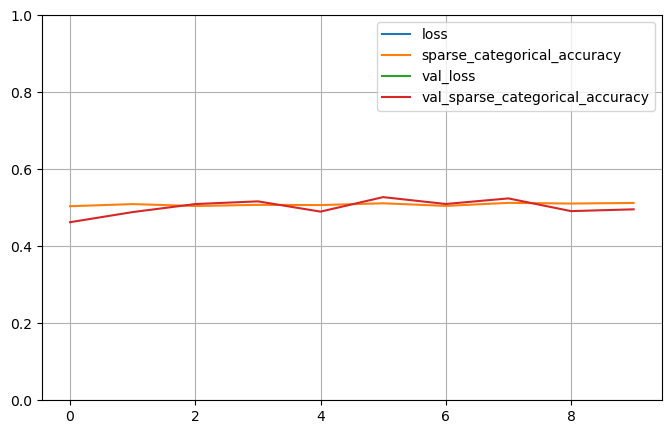

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Visualización mediante TensorBoard

In [82]:
%tensorboard --logdir logs/fit

## Evitar el sobreajuste

* Uno de los problemas de las Redes Neuronales Profundas (*Deep Neural Networks*, DNNs) es su tendencia al sobreajuste, debido al alto número de parámetros.

In [83]:
model = keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        tf.keras.layers.Dense(50, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

model.summary()

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_tr, y_tr, validation_split=0.9, epochs=20)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_80 (Dense)            (None, 50)                39250     
                                                                 
 dense_81 (Dense)            (None, 50)                2550      
                                                                 
 dense_82 (Dense)            (None, 50)                2550      
                                                                 
 dense_83 (Dense)            (None, 50)                2550      
                                                                 
 dense_84 (Dense)            (None, 50)                2550      
                                                                 
 dense_85 (Dense)            (None, 10)              

<div class="qst">

* Dada la evolución de los errores representada en la siguiente celda, discutir si se distingue sobreajuste del modelo.

</div>

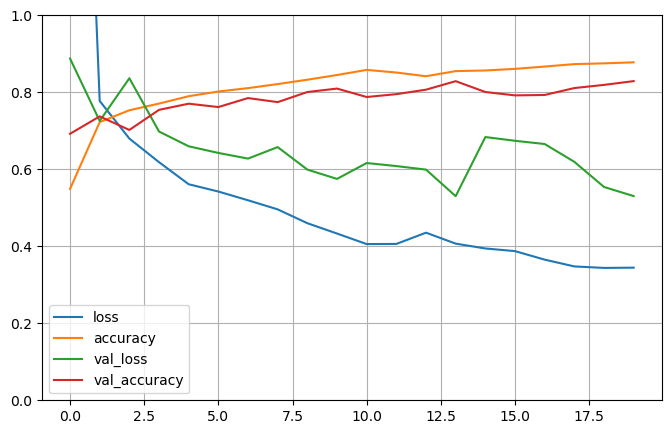

In [84]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### *Dropout*

* Una aproximación típica para regularizar una DNN es el *dropout*.
* Durante el entrenamiento, un cierto porcentaje $r$ de las entradas a una cierta capa se ponen a $0$, mientras las otras se multiplican por $\frac{1}{1 - r}$ para compensar el cambio de escala.
* La red «aprende» a distribuir el procesamiento de la información, en lugar de confiar en unidades sueltas.
* Durante la predicción sobre nuevos datos se usan todas las unidades de manera usual.

El siguiente código genera un problema sencillo de regresión en una dimensión.

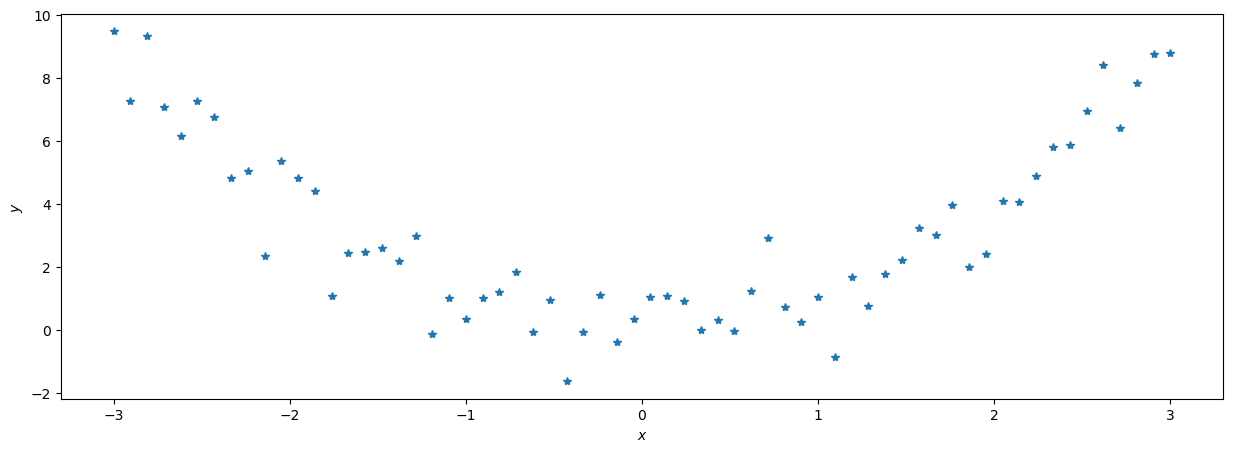

In [85]:
np.random.seed(seed)

n_pat = 64
lim = 3
noise = 1e0
x_orig = np.linspace(- lim, lim, n_pat)
x_long = np.linspace(- lim, lim, 10 * n_pat)
y = np.square(x_orig) + noise * np.random.randn(n_pat)
x = x_orig.reshape(-1, 1)

plt.plot(x_orig, y, "*")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

<div class="qst">

* Analizar la influencia de las capas de Dropout usadas en la siguiente celda.
* Discutir si estas capas están evitando o no el sobreajuste.

</div>

Fitting NN with dropout at  0%...
20/20 [==============================] - 0s 2ms/step
Fitting NN with dropout at 20%...
20/20 [==============================] - 0s 2ms/step
Fitting NN with dropout at 40%...
20/20 [==============================] - 0s 2ms/step
Fitting NN with dropout at 60%...
20/20 [==============================] - 0s 2ms/step
Fitting NN with dropout at 80%...
20/20 [==============================] - 0s 2ms/step


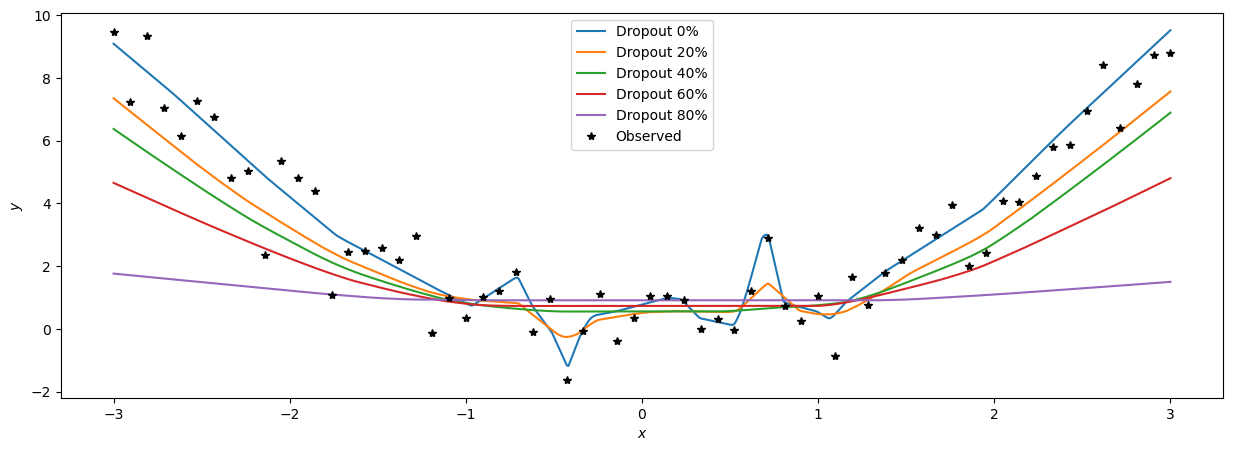

In [86]:
for d in (0.0, 0.2, 0.4, 0.6, 0.8):
    inputs = keras.Input(shape=(1))
    layers = keras.layers.Dense(100, activation="relu")(inputs)
    layers = keras.layers.Dropout(d)(layers)
    layers = keras.layers.Dense(100, activation="relu")(layers)
    layers = keras.layers.Dropout(d)(layers)
    layers = keras.layers.Dense(100, activation="relu")(layers)
    outputs = keras.layers.Dense(1)(layers)
    model = keras.Model(inputs, outputs)
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        metrics=["mean_squared_error"],
    )

    epochs = 1000
    print("Fitting NN with dropout at {:2.0f}%...".format(100 * d))
    model.fit(x, y, epochs=epochs, verbose=0)
    plt.plot(x_long, model.predict(x_long.reshape(-1, 1)), label="Dropout {:.0f}%".format(100 * d))

plt.plot(x_orig, y, "*k", label="Observed")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()
plt.show()

### Regularización

* Las técnicas de regularización $L_1$ y $L_2$ son muy utilizadas en el entrenamiento de modelos de ML para evitar el sobreajuste.
    * $L_1$ (Lasso Regression): Tiene como objetivo minimizar el valor absoluto de los pesos.
    * $L_2$ (Ridge Regression, *weight decay*): Tiene como objetivo minimizar la magnitud al cuadrado de los pesos.
* La principal diferencia entre $L_1$ y $L_2$ es que $L_1$ permite discriminar qué características son más importantes en el modelo, llevando a $0$ aquellas características de poco peso. $L_2$ es más eficiente computacionalmente.
* En resumen, las técnicas de regularización $L_1$ y $L_2$ consiguen que el modelo tenga menos varianza, lo que ayuda a combatir el sobreajuste.

<div class="qst">

* Analizar la influencia de la regularización $L_2$ usada en la siguiente celda.
* Discutir si esta regularización están evitando o no el sobreajuste.

</div>

Fitting NN with regularization at 1e-05...
20/20 [==============================] - 0s 2ms/step
Fitting NN with regularization at 1e-04...
20/20 [==============================] - 0s 2ms/step
Fitting NN with regularization at 1e-03...
20/20 [==============================] - 0s 2ms/step
Fitting NN with regularization at 1e-02...
20/20 [==============================] - 0s 2ms/step
Fitting NN with regularization at 1e-01...
20/20 [==============================] - 0s 2ms/step
Fitting NN with regularization at 1e+00...
20/20 [==============================] - 0s 2ms/step
Fitting NN with regularization at 1e+01...
20/20 [==============================] - 0s 2ms/step


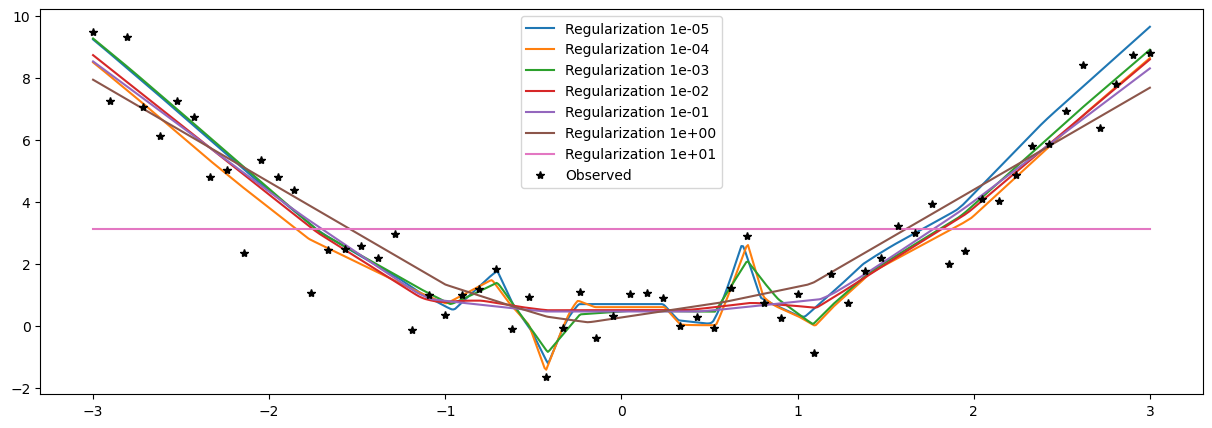

In [87]:
for l in np.logspace(-5, 1, 7):
    inputs = keras.Input(shape=(1))
    layers = keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(l))(inputs)
    layers = keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(l))(layers)
    layers = keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(l))(layers)
    outputs = keras.layers.Dense(1)(layers)
    model = keras.Model(inputs, outputs)
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        metrics=["mean_squared_error"],
    )

    epochs = 1000
    print("Fitting NN with regularization at {:.0e}...".format(l))
    model.fit(x, y, epochs=epochs, verbose=0)
    plt.plot(x_long, model.predict(x_long.reshape(-1, 1)), label="Regularization {:.0e}".format(l))

plt.plot(x_orig, y, "*k", label="Observed")
plt.legend()
plt.show()

### Generación de muestras

* Otra manera de evitar el sobreajuste es usar una gran cantidad de datos de entrenamiento.
    * No siempre está disponible, dependerá del problema.
* Una solución es generar nuevos datos (*data augmentation*).
* Este proceso no es trivial, los datos generados tienen que ser relevantes para el problema.
* Diferentes aproximaciones:
    * Perturbar con ruido.
    * Ajustar la distribución de los datos originales.
    * Usar conocimiento experto sobre las variaciones en la vida real (algo particularmente útil con imágenes).

A continuación se carga una imagen de ejemplo.

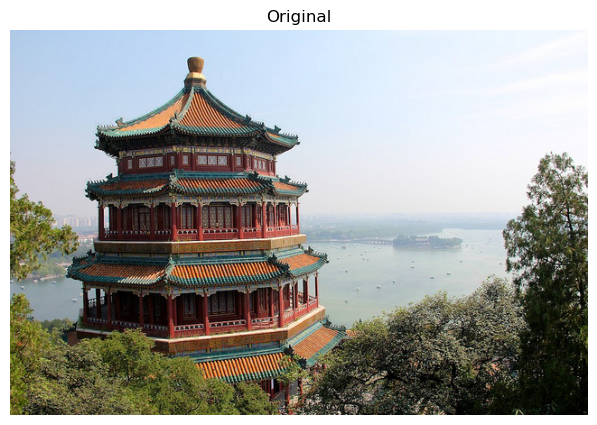

In [88]:
from sklearn.datasets import load_sample_images

china = load_sample_images().images[0]

plt.imshow(china)
plt.title("Original")
plt.axis("off")
plt.show()

La siguiente celda perturba la imagen anterior, generando nuevas muestras.

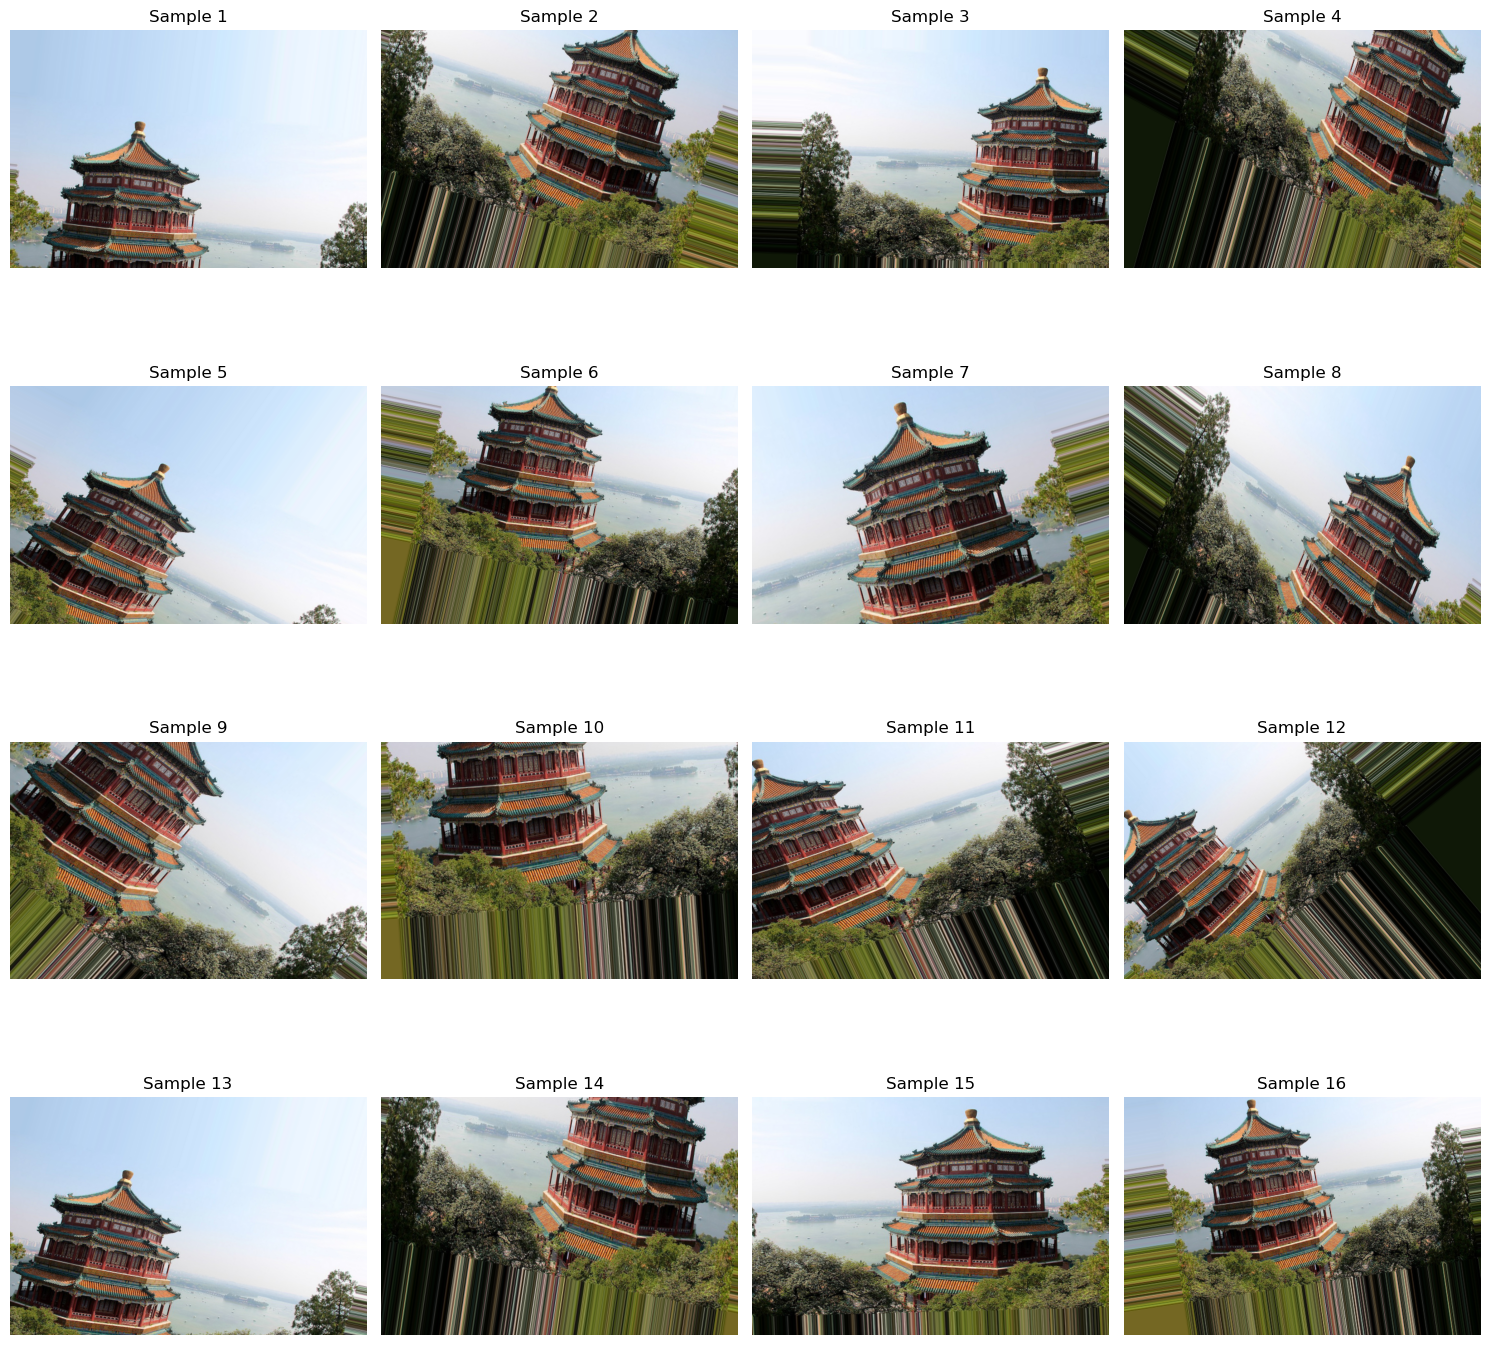

In [89]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")

x = keras.preprocessing.image.img_to_array(china)
x = x.reshape((1,) + x.shape)

n_rows = 4
n_cols = 4
n_images = n_rows * n_cols

i = 0
plt.figure(figsize=(15, 15))
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > n_images:
        break

    plt.subplot(n_rows, n_cols, i)
    plt.imshow(keras.preprocessing.image.array_to_img(batch[0]))
    plt.title("Sample {}".format(i))
    plt.axis("off")

plt.tight_layout()
plt.show()

<div class="qst">

* Observar los diferentes efectos de distorsión en las imágenes anteriores, identificándolo con las opciones usadas en la generación.

</div>

## *Transfer Learning*

* Para evitar el sobreajuste, se puede pre-entrenar el modelo en un conjunto de datos grande, y luego adaptarlo al problema en cuestión.
* Esta aproximación se conoce como *transfer learning*:
    1. Tomar un modelo entrenado con éxito sobre un conjunto de datos grande (el modelo completo, o solo una parte de él).
    1. Añadir las capas necesarias para adaptarlo al problema en cuestión.
    1. Entrenar las nuevas capas.
    1. Entrenar todas las capas con una tasa de aprendizaje pequeña (*fine-tuning*).
* Keras facilita esta aproximación.
    * Proporciona varias arquitecturas pre-entrenadas.
    * Permite seleccionar qué parámetros se entrenarán, dejando los demás congelados.

# Autoencoder

## Repaso de Autoencoders

Un AutoEncoder (AE) es un tipo de red neuronal que aprende a replicar a la salida exactamente la misma información que recibe en la entrada.
* Las capas de entrada y de salida deben tener el mismo número de unidades.
* La clave está en la capa oculta, donde la red almacena una representación abstracta de la información.

<img src="figures/AE.svg" alt="AutoEncoder.">

* El aprendizaje de los AE es no supervisado.
* El AE trata de modelar la identidad, $f(\mathbf{x}_i) = \mathbf{x}_i$.
* El AE puede enfrentarse a este problema de dos formas:
    1. Comportamiento deseado: El AE aprende a codificar (y posiblemente comprimir) los datos en la capa oculta.
    2. Comportamiento trivial: El AE copia la entrada $\mathbf{x}_i$ capa a capa, desde la entrada hasta la salida.
* Es necesario forzar al AE a comprimir los datos para evitar el comportamiento trivial.
* El AE queda divido en dos subredes.
    1. El codificador, donde se realiza la extracción de características.
    2. El decodificador, donde se invierte la extracción de características.

## Autoencoders en Keras

### Conjunto de datos

En la siguiente celda se carga el conjunto de dígitos MNIST, que se utilizará para ilustrar varios de los modelos.

In [ ]:
(x_tr, y_tr), (x_te, y_te) = keras.datasets.mnist.load_data()

print("Number of axis:   ", x_tr.ndim)
print("Dimension (train):", x_tr.shape)
print("Dimension (test): ", x_te.shape)
print("Data type:        ", x_tr.dtype)

plt.imshow(x_tr[0])
plt.axis("off")
plt.show()

# The pixels are transformed to the interval [0, 1].
x_tr = x_tr.astype("float32") / 255.
x_te = x_te.astype("float32") / 255.

# Each image is converted into a 1-dimensional vector.
x_tr_1D = x_tr.reshape(len(x_tr), -1)
x_te_1D = x_te.reshape(len(x_te), -1)

### Constructor del Autoencoder

* Para construir un AE en Keras basta con determinar la arquitectura:
    * Capa de entrada, correspondiente a los datos que se van a codificar.
    * Capas del codificador, encargadas de comprimir la información.
    * Capas del decodificador, encargadas de descomprimir la información.

In [ ]:
def autoencoder_builder(inp_lay, enc_lays, dec_lays, optimizer="adam"):
    # AE.
    autoencoder = keras.Sequential([inp_lay] + enc_lays + dec_lays)
    autoencoder.compile(optimizer=optimizer, loss="mse", metrics=["mse"])

    # Encoder.
    encoder = keras.Sequential([inp_lay] + enc_lays)

    # Decoder.
    decoder = keras.Sequential([keras.Input(shape=enc_lays[-1].output_shape[1:])] + dec_lays)

    return [autoencoder, encoder, decoder]

### Autoencoders simples

* Una primera forma de garantizar que el AE comprime la información es forzando a la capa oculta a tener una dimensión mucho menor que la dimensión de entrada.

<img src="figures/AESmall.svg" alt="AutoEncoder con dimensión reducida.">

#### Definición del modelo

<div class="qst">

* Completar la siguiente celda para definir la capa de entrada (`inp_lay`), las capas del codificador (`enc_lays`) y las capas del decodificador (`dec_lays`), de manera que en el AE resultante:
    * La capa de entrada tome un vector de dimensión $784$ ($28 \times 28$).
    * El codificador tenga una única capa densa de tamaño `encoding_dim` (correspondiente a la dimensión reducida) con función de activación ReLU.
    * El decodificador deshaga la codificación restaurando los datos a la dimensión original ($784$), con función de activación sigmoidal.

</div>

In [ ]:
encoding_dim = 16

################################
# Insertar código.

################################

[autoencoder, encoder, decoder] = autoencoder_builder(inp_lay,
                                                      enc_lays,
                                                      dec_lays)
autoencoder.summary()

#### Entrenamiento

* El AE se entrena simplemente minimizando el error cuadrático, como cualquier otra red.

In [ ]:
hisory = autoencoder.fit(x_tr_1D, x_tr_1D, epochs=10, batch_size=256, shuffle=True)

#### Predicción

* Las imágenes se pueden codificar y decodificar aplicando a los datos originales las subredes del codificador y del decodificador, respectivamente.

In [ ]:
encoded_imgs = encoder.predict(x_te_1D)
decoded_imgs = decoder.predict(encoded_imgs)
print("Prediction error: {:.3f}".format(autoencoder.evaluate(x_te_1D, x_te_1D, verbose=0)[1]))

#### Reconstrucción

Algunos ejemplos de las imágenes originales y reconstruidas se muestran a continuación.

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_te[i].reshape(28, 28))
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.axis("off")

plt.show()

#### *Embedding*

* Se puede aplicar solo el codificador para realizar una reducción de dimensión de los datos iniciales.

In [ ]:
for i in range(10):
    plt.scatter(encoded_imgs[y_te==i, 0], encoded_imgs[y_te==i, 1], label="Digit {}".format(i))

plt.legend()
plt.show()

<div class="qst">

* Replicar el procedimiento anterior fijando la dimensión reducida a $2$.
* ¿Tiene suficiente expresividad el AE?
* ¿El *embedding* resultante es mejor o peor?

</div>

### Autoencoders *sparse*

* Una forma de garantizar la comprensión de información cuando la capa oculta es más grande que la de entrada es forzar a que los AE produzcan una codificación *sparse* de los datos (Sparse AE).
    * Se utiliza una regularización que induzca dispersión en la capa oculta.
* Solo se activan un subconjunto de las unidades ocultas a la vez.

<img src="figures/AESparse.svg" alt="Sparse AutoEncoder.">

#### Definición del modelo

<div class="qst">

* Completar la siguiente celda para definir la capa de entrada (`inp_lays`), las capas del codificador (`enc_lays`) y las capas del decodificador (`dec_lays`), de manera que en el AE resultante:
    * La capa de entrada tome un vector de dimensión $784$ ($28 \times 28$).
    * El codificador tenga una única capa densa de tamaño `encoding_dim` (correspondiente a la dimensión extendida) con función de activación ReLU. Esta capa tendrá además una regularización para que la salida sea dispersa.
    * El decodificador deshaga la codificación restaurando los datos a la dimensión original ($784$), con función de activación sigmoidal.

<div class="notes">

* Para aplicar una regularización a la salida de una capa basta usar la opción `activity_regularizer` de la capa. En concreto, para que se induzca dispersión se puede usar una regularización de tipo $L_1$ (e.g. `activity_regularizer=keras.regularizers.l1(1e-3)`).

</div>
</div>

In [ ]:
encoding_dim = 800

################################
# Insertar código.

################################

[autoencoder, encoder, decoder] = autoencoder_builder(inp_lay,
                                                      enc_lays,
                                                      dec_lays)
autoencoder.summary()

#### Entrenamiento

* El entrenamiento del Sparse AE garantizará que solo un subconjunto de las unidades se activan a la vez.

In [ ]:
hisory = autoencoder.fit(x_tr_1D, x_tr_1D, epochs=10, batch_size=256, shuffle=True)

#### Predicción

In [ ]:
encoded_imgs = encoder.predict(x_te_1D)
decoded_imgs = decoder.predict(encoded_imgs)
print("Prediction error: {:.3f}".format(autoencoder.evaluate(x_te_1D, x_te_1D, verbose=0)[1]))

#### Reconstrucción

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_te[i].reshape(28, 28))
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.axis("off")

plt.show()

#### *Embedding*

In [ ]:
for i in range(10):
    plt.scatter(encoded_imgs[y_te==i, 0], encoded_imgs[y_te==i, 1], label="Digit {}".format(i))

plt.legend()
plt.show()

* La codificación de un Sparse AE es dispersa, por tanto muchas de las coordenadas son iguales a $0$.

In [ ]:
print("Sparsity: {:.2f}%".format(100 * (encoded_imgs == 0).mean()))

<div class="qst">

* ¿Qué sucede si se pone a $0$ la regularización?
* ¿Se comprime realmente la información?

</div>

### Autoencoders profundos

* Una ampliación de los AEs estándar es usar AEs profundos.
    * Una DNN realiza la codificación.
    * Una DNN (normalmente simétrica a la anterior) realiza la decodificación.

#### Definición del modelo

<div class="qst">

* Completar la siguiente celda para definir la capa de entrada (`inp_lay`), las capas del codificador (`enc_lays`) y las capas del decodificador (`dec_lays`), de manera que en el AE resultante:
    * La capa de entrada tome un vector de dimensión $784$ ($28 \times 28$).
    * El codificador tenga tres capas completamente conectadas con $128$, $64$ y $2$ unidades y activación ReLU.
    * El decodificador deshaga la codificación restaurando los datos a la dimensión original ($784$), usando una arquitectura simétrica a la anterior, también de tres capas (las dos primeras con activación ReLU, y la última con activación sigmoidal).

</div>

In [ ]:
################################
# Insertar código.

################################

[autoencoder, encoder, decoder] = autoencoder_builder(inp_lay,
                                                      enc_lays,
                                                      dec_lays)
autoencoder.summary()

#### Entrenamiento

* Para los Deep AEs se usa un entrenamiento similar al estándar en DNNs.

In [ ]:
hisory = autoencoder.fit(x_tr_1D, x_tr_1D, epochs=10, batch_size=256, shuffle=True)

#### Predicción

In [ ]:
encoded_imgs = encoder.predict(x_te_1D)
decoded_imgs = decoder.predict(encoded_imgs)
print("Prediction error: {:.3f}".format(autoencoder.evaluate(x_te_1D, x_te_1D, verbose=0)[1]))

#### Reconstrucción

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(x_te[i].reshape(28, 28))
    plt.axis("off")

    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.axis("off")

plt.show()

#### *Embedding*

In [ ]:
for i in range(10):
    plt.scatter(encoded_imgs[y_te==i, 0], encoded_imgs[y_te==i, 1],label="Digit {}".format(i))

plt.legend()
plt.show()

<div class="qst">

* Considerando que la dimensión de codificación es $2$, ¿el *embedding* resultante es mejor o peor que los anteriores? ¿Por qué?

</div>

# Redes Neuronales Convolucionales

## Repaso de Redes Neuronales Convolucionales

* Los modelos de ML suelen ser sensibles ante traslaciones de las entradas, de manera que un cambio como
$$ \begin{pmatrix} 0 & 1 & 3 & 5 & 0 & 0 \end{pmatrix} \to \begin{pmatrix} 0 & 0 & 1 & 3 & 5 & 0 \end{pmatrix} $$
altera completamente las predicciones.
* Este tipo de perturbaciones son muy comunes en algunos problemas reales, como los relacionados con imágenes.
    * Dos imágenes con una ligera traslación deberían dar una salida similar.
    * Sin embargo, en DNN estándar este no es el caso.
* Las Redes Neuronales Convolucionales (*Convolutional Neural Networks*, CNNs) afrontan este problema mediante:
    * Capas de convolución, que aplican filtros sobre las imágenes, detectando diferentes estructuras.
    * Capas de *pooling*, que reducen la dimensión y proporcionan invarianza ante traslaciones.
* La diferencia fundamental con respecto a los métodos de filtrado de imágenes tradicionales es que en las CNN los filtros no se fijan de antemano, sino que se ajustan durante el entrenamiento.

## Convolución de imágenes en Keras

### Imagen original

La siguiente celda carga una imagen de ejemplo.

In [ ]:
from sklearn import datasets

china = datasets.load_sample_images().images[0]
china = china[:china.shape[0], :china.shape[0], :] / 255.0
plt.imshow(china)
plt.title("Original")
plt.axis("off")
plt.show()

### Convolución con diferentes filtros

* Aunque la potencia de las CNN es que los filtros se aprenden de los datos, en Keras se puede inicializar el valor a mano de las capas convolucionales para ver el efecto de distintos filtros.

In [ ]:
kv = []
kv.append(np.array([[0, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]]))
kv.append(np.array([[1, 1, 1],
                    [0, 0, 0],
                    [-1, -1, -1]]))
kv.append(kv[-1].T)
kv.append(np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]]))
kv.append(np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]]))
kv.append(1 / 256 * np.array([[1, 4, 6, 4, 1],
                              [4, 16, 24, 16, 4],
                              [6, 24, 36, 24, 6],
                              [4, 16, 24, 16, 4],
                              [1, 4, 6, 4, 1]]))
lv = ("Identity", "Edge H", "Edge V", "Edges", "Sharpen", "Gaussian")

tf.get_logger().setLevel("ERROR")

inp = tf.constant([china])
for k, l in zip(kv, lv):
    def kernel_init(shape, dtype=None):
        kernel = np.zeros(shape)
        kernel[:, :, 0, 0] = k
        kernel[:, :, 1, 1] = k
        kernel[:, :, 2, 2] = k
        return kernel

    model = keras.Sequential([keras.layers.Conv2D(3,
                                                  k.shape,
                                                  kernel_initializer=kernel_init,
                                                  input_shape=china.shape)])
    model.build()
    out = model.predict(inp)[0]
    out = np.clip(out, 0, 1)
    
    plt.subplot(1, 3, 1)
    plt.imshow(china)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(k)
    plt.title("Kernel ({})".format(l))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(out)
    plt.title("Convoluted Image")
    plt.axis("off")

    plt.show()

<div class="qst">

* ¿Qué efecto producirá un filtro formado por una matriz de tamaño $20 \times 20$ con un valor contante de $\frac{1}{400}$?
* Comprobar el efecto producido modificando el código anterior.

</div>

In [ ]:
################################
# Insertar código.

################################

## Redes Neuronales Convolucionales en Keras

### Conjunto de datos

A continuación se modifica el conjunto de datos de MNIST para que cada ejemplo tenga dimensión $28 \times 28 \times 1$, ya que las capas convolucionales de Keras esperan que la última dimensión sea el canal (en este caso solo hay 1, ya que son imágnes en escala de grises).

In [ ]:
x_tr = x_tr.reshape(-1, 28, 28, 1)
x_te = x_te.reshape(-1, 28, 28, 1)

y_tr = keras.utils.to_categorical(y_tr, num_classes=10)
y_te = keras.utils.to_categorical(y_te, num_classes=10)

### Redes Neuronales Convolucionales profundas

#### Definición del modelo

* En Keras se pueden definir fácilmente las CNN usando las capas convolucionales.

In [ ]:
cnn = keras.Sequential()

cnn.add(keras.layers.Conv2D(32, kernel_size=(3,3),  activation="relu", input_shape=(28, 28, 1)))
cnn.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
cnn.add(keras.layers.Dropout(0.2))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(128, activation="relu"))
cnn.add(keras.layers.Dropout(0.4))
cnn.add(keras.layers.Dense(10, activation="softmax"))

cnn.summary()

<div class="qst">

* Comprobar el número de parámetros libres de la segunda capa.

</div>

In [ ]:
################################
# Insertar código.

################################

In [ ]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Entrenamiento

* El entrenamiento de la CNN es similar al de cualquier otra DNN.

In [ ]:
history = cnn.fit(x_tr, y_tr, validation_split=0.75, batch_size=256, epochs=5)

#### Evaluación

In [ ]:
print("Test accuracy: {:.3f}%".format(100 * cnn.evaluate(x_te, y_te, verbose=0)[1]))

* Se puede pintar la evolución de los errores para detectar posibles problemas de sobreajuste.

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"])

plt.show()

#### Predicción

In [ ]:
import seaborn as sn

preds = cnn.predict(x_te)
y_te_t = np.argmax(y_te, axis=1)
y_te_p = np.argmax(preds, axis=1)

cm = confusion_matrix(y_te_t, y_te_p)

plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.axis("equal")
plt.axis("off")

plt.show()

# Redes Neuronales Recurrentes

## Repaso de Redes Neuronales Recurrentes

* La mayoría de modelos de ML asumen independencia entre los ejemplos.
* Hay muchas situaciones en los que esta hipótesis no es cierta, y los patrones son muy dependientes del contexto:
    * Predicción de series temporales.
    * Procesamiento del lenguaje natural.
* Las Redes Neuronales Recurrentes (*Recurrent Neural Networks*, RNNs) tratan de paliar este problema a través de conexiones *backward*.
* En concreto, las unidades *Long Short-Term Memory* (LSTM) son componentes diseñadas para retener información de patrones anteriores, a más largo plazo que otras RNNs estándar.
* Estas unidades suelen tener los siguientes componentes:
    * Celda, que constituye la memoria de la unidad LSTM.
    * Puerta de entrada, que controla la influencia de la nueva entrada en la celda.
    * Puerta de olvido, que controla cuánto se mantiene el valor en la celda.
    * Puerta de salida, que controla cuánto se usa el valor de la celda para calcular la salida de la unidad.
* Hay conexiones de entrada y salida a la LSTM (algunas recurrentes).
* Los pesos de todas estas conexiones (incluidas las puertas) se aprenden durante el entrenamiento.
* La red aprende qué patrones debe retener.

<img src="figures/LSTM.svg" alt="Unidad LSTM.">

## Redes Neuronales Recurrentes en Keras

### Conjunto de datos

A continuación se genera una serie temporal sencilla como ejemplo para ilustrar las RNNs.

In [ ]:
x = np.linspace(- 8 * np.pi, 8 * np.pi, 513)
x = np.sin(x)

y = x[1:].reshape(- 1, 1)
x = x[:-1].reshape(- 1, 1, 1)

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, shuffle=False)
plt.plot(range(len(y_tr.ravel())), y_tr.ravel())
plt.plot(range(len(y_tr.ravel()), len(y_tr.ravel()) + len(y_te.ravel())), y_te.ravel())
plt.show()

### Redes Neuronales Recurrentes LSTM

#### Definición del modelo

* En Keras existe un tipo de capa LSTM, que incluye tantas unidades LSTM como se especifique.

In [ ]:
rnn = keras.Sequential()
rnn.add(keras.layers.LSTM(50, batch_input_shape=(1, 1, 1), stateful=True))
rnn.add(keras.layers.Dense(1))

rnn.summary()

In [ ]:
rnn.compile(loss="mean_squared_error", optimizer="adam")

#### Entrenamiento

In [ ]:
history_rnn = rnn.fit(x_tr, y_tr, epochs=10, batch_size=1, shuffle=False)

#### Predicción

In [ ]:
rnn.reset_states()
rnn.predict(x_tr, batch_size=1)
preds_rnn = rnn.predict(x_te, batch_size=1)

In [ ]:
plt.plot(y_te.ravel(), label="Real")
plt.plot(preds_rnn.ravel(), label="Pred")
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(x_te, y_te)
plt.xlabel("Input")
plt.ylabel("Real")
plt.subplot(1, 2, 2)
plt.scatter(x_te, preds_rnn)
plt.xlabel("Input")
plt.ylabel("Pred")
plt.show()

<div class="qst">

* Observando la predicción anterior, ¿la salida de la RNN depende solo de su entrada (es decir, el valor en el instante anterior) o depende también del contexto? ¿Por qué?

</div>

# Redes Generativas Adversarias

## Introducción a las Redes Generativas Adversarias

* Una aplicación no supervisada de las DNNs consiste en generar nuevas muestras, siguiendo una distribución previamente aprendida.
    * Por ejemplo, generar caras realistas a partir de una base de datos de caras.
* Surgen dos preguntas fundamentales:
    1. ¿Cómo entrenar este tipo de modelos?
    1. ¿Qué entrada usar para generar los nuevos ejemplos?
* Las Redes Generativas Adversarias (*Generative Adversarial Networks*, GANs) afrontan este problema del siguiente modo:
    1. Se sigue una aproximación adversaria para entrenar dos redes en un juego competitivo.
    1. Se usa ruido aleatorio para generar las muestras.
* Las GANs están compuestas por dos redes: una generadora y otra discriminatoria.
* La red generadora recibe como entrada ruido, y produce como salida muestras de la distribución modelada.
* La red discriminatoria recibe como entrada imágenes, y como salida trata de distinguir si son imágenes reales o generadas por la red generadora.
* La magia de las GANs se produce en el entrenamiento adversario, donde se repite el siguiente proceso:
    1. Se usa la generadora para producir imágenes falsas.
    1. Se entrena la discriminadora para distinguir entre las imágenes falsas y las reales.
    1. Se entrena la generadora para maximizar el error de la discriminadora.

<img src="figures/GAN.svg" alt="GAN.">

## Redes Generativas Adversarias

### Discriminador

* El discriminador es simplemente una red profunda que toma como entrada una imagen, y realiza una clasificación binaria.

In [ ]:
def create_discriminator():
    discriminator = keras.Sequential()

    discriminator.add(keras.Input(shape=(28, 28, 1)))
    discriminator.add(keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
    discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(keras.layers.Conv2D(128, kernel_size=4, strides=1, padding="same"))
    discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(keras.layers.Flatten())
    discriminator.add(keras.layers.Dropout(0.2))
    discriminator.add(keras.layers.Dense(1, activation="sigmoid"))

    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

    return discriminator

discriminator = create_discriminator()
discriminator.summary()

### Generador

* El generador es una red profunda que toma un vector (aleatorio) de una cierta dimensión, y produce como salida una imagen con el tamaño especificado.
* Es común que su arquitectura sea simétrica a la del disciminador.

In [ ]:
def create_generator():
    generator = keras.Sequential()
    
    generator.add(keras.Input(shape=(100, )))
    generator.add(keras.layers.Dense(7 * 7 * 128))
    generator.add(keras.layers.Reshape((7, 7, 128)))
    generator.add(keras.layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding="same"))
    generator.add(keras.layers.LeakyReLU(alpha=0.2))
    generator.add(keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    generator.add(keras.layers.LeakyReLU(alpha=0.2))
    generator.add(keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"))
    generator.add(keras.layers.LeakyReLU(alpha=0.2))
    generator.add(keras.layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"))
    
    return generator

generator = create_generator()
generator.summary()

### GAN

* La GAN es la concatenación del generador y el discriminador.

In [ ]:
def create_gan(discriminator, generator):
    gan_input = keras.Input(shape=(100,))
    gan = keras.Model(inputs=gan_input, outputs=discriminator(generator(gan_input)))
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

### Entrenamiento

La siguiente función permite pintar muestras de las imágenes generadas.

In [ ]:
def plot_generated_images(generator, dim=(5, 5), figsize=(5, 5)):
    examples = np.prod(dim)
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        image = generated_images[i]

        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
max_iter = 101
batch_size = 128

(x_tr, y_tr), (x_te, y_te) = keras.datasets.mnist.load_data()
x = x_tr[y_tr == 4].astype("float32") / 255.

for i in range(max_iter):

    print("Iteration: {}".format(i), end="\r")
    if (i % 10) == 0:
        plot_generated_images(generator)

    noise = np.random.normal(0, 1, [batch_size, 100])

    generated_images = generator.predict(noise)
    real_images = x[np.random.randint(low=0, high=x.shape[0], size=batch_size)]

    X = np.concatenate([real_images, generated_images[:, :, :, 0]])
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

    y_dis = np.zeros(2 * batch_size)
    y_dis[:batch_size] = 1.0

    discriminator.trainable=True
    discriminator.train_on_batch(X, y_dis)

    noise = np.random.normal(0, 1, [batch_size, 100])
    y_gen = np.ones(batch_size)

    discriminator.trainable=False
    gan.train_on_batch(noise, y_gen)

<div class="qst">

* Analizar el entrenamiento de la GAN.
* ¿Por qué se modifican las etiquetas de los patrones?

</div>

# Aprendizaje por Refuerzo

## Introducción al Aprendizaje por Refuerzo

### Definición

* Además del Aprendizaje Supervisado y el Aprendizaje No Supervisado, existe otro paradigma denominado Aprendizaje por Refuerzo (*Reinforcement Learning*, RL), que trata de determinar qué acciones debe tomar un agente en un cierto entorno para maximizar una recompensa.
* Este tipo de problemas suele formalizarse como un Proceso de Markov de Decisión:
    * $s_t$ es el estado a tiempo $t$.
    Algunos estados son terminales, en el sentido de que terminan el episodio.
    * $r_t$ es la recompensa obtenida a tiempo $t$.
    * $a_t$ es la acción que toma el agente a tiempo $t$.
    * $p_s(s_2 | s_1, a)$ es el modelo de transición, que modela la probabilidad de ir del estado $s_1$ al estado $s_2$ cuando se toma la acción $a$.
    * $p_r(r | s, a)$ es el modelo de recompensa, que modela la probabilidad de obtener una recompensa $r$ desde el estado $s$ cuando se toma la acción $a$.
* El objetivo del RL es encontrar una política, una probabilidad $\pi(a | s)$ que maximice la recompensa esperada.

### Resolución de problemas de RL

* Si las probabilidades reales $p_s$ y $p_r$ se conocen, entonces la política óptima $\pi(a | s)$ puede calcularse mediante programación dinámica.
* En general estas distribuciones son desconocidas, así que se pueden seguir dos aproximaciones distintas:
    1. Métodos basados en modelo, que tratan de modelar $p_s$ y $p_r$, y luego estimar $\pi(a | s)$ a partir de estos modelos.
    1. Métodos *model-free*, que tratan directamente de optimizar la política $\pi(a | s)$.

#### Método Actor-Critic

* En este método el agente aprende a predecir, a partir del estado actual, dos salidas distintas:
    1. La política, $\pi(a | s)$. La parte del agente encargada de esta salida es el actor.
    1. La recompensa estimada en el futuro. La parte del agente encargada de esta salida es el crítico.
* El crítico aprende comparando la recompensa obtenida en episodios reales con su predicción, y haciendo descenso por gradiente.
* Por otro lado, el actor utiliza *policy gradient* (estima el gradiente mediante el método de Montecarlo), modificado para usar la información producida por el crítico.

## Aprendizaje por Refuerzo en Keras

### Conjunto de datos: CartPole v1

#### Introducción

* Este problema consiste en un poste articulado sobre un carro, que se mueve por una vía.
* El poste comienza vertical, y el objetivo es impedir que caiga cambiando la velocidad del carro.

#### Estado

| Índice| Observación| Mín | Máx|
|:-:|:-:|:-:|:-:|
| 0 | Posición del Carro | $$-2.4$$ | $$2.4$$ |
| 1 | Velocidad del Carro  | $$-\infty$$ | $$\infty$$ |
| 2 | Ángulo del Poste | $$\sim -41.8^\circ$$ | $$\sim 41.8^\circ$$ |
| 3 | Velocidad del Poste (en el Extremo) | $$-\infty$$ | $$\infty$$ |

* El estado inicial es aleatorio, según una uniforme $\pm 0.05$.

#### Acciones y recompensa

| Índice | Acción |
|:-:|:-:|
| 0 | Empujar el carro hacia la izquierda |
| 1 | Empujar el carro hacia la derecha|

* La recompensa es $1$ para cada instante de tiempo.

#### Fin del episodio

* El episodio termina si se cumple cualquiera de las siguientes condiciones:
    1. El ángulo del poste es mayor que $\pm 12^\circ$.
    2. La posición del carro es mayor que $\pm 2.4$ (el centro del carro abandona la imagen).
    3. El episodio dura más de $500$ pasos.

#### Política aleatoria

La siguiente celda crea el entorno del problema.

In [ ]:
env = gym.make("CartPole-v1")

El siguiente código genera un episodio siguiendo la política especificada (si no hay modelo, se selecciona la siguiente acción aleatoriamente).

In [ ]:
def generate_sequence(env, early_stop=True, model=None, n_steps=500):
    state = env.reset()
    for i in range(n_steps):
        env.render()
        if model is None:
            action = env.action_space.sample()
        else:
            action_probs, _ = model.predict(tf.expand_dims(tf.convert_to_tensor(state), 0))
            p = np.squeeze(action_probs)
            action = np.random.choice(len(p), p=p)
        state, _, done, _ = env.step(action)
        if early_stop and done:
            print("Finished after {} steps".format(i))
            break

In [ ]:
generate_sequence(env, model=None, early_stop=True)

### Método *Actor-Critic* con Redes Neuronales

#### Configuración

Esta celda configura el modelo.
El parámetro $\gamma$ (variable `gamma`) determina el olvido o factor de descuento de las recompensas pasadas.

In [ ]:
gamma = 0.99
max_steps_per_episode = 10000
eps = np.finfo(np.float32).eps.item()

#### Modelo

La siguiente celda construye la red neuronal que implementará tanto el actor como el crítico, compartiendo la entrad y la capa oculta, y usando una capa de salida diferente para la política (actor) y la estimación de recompensa (crítico).

In [ ]:
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
num_hidden = 128

inputs = keras.layers.Input(shape=(num_inputs,))
common = keras.layers.Dense(num_hidden, activation="relu")(inputs)
action = keras.layers.Dense(num_actions, activation="softmax")(common)
critic = keras.layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

<div class="qst">

* ¿Cuál es la función de activación de cada capa de salida?
¿Por qué?

</div>

#### Entrenamiento

* El entrenamiento consiste básicamente en completar episodios, acumulando la pérdida tanto del actor como del crítico a lo largo de todos los pasos de un episodio.
* Durante cada episodio, se sigue la política aprendida hasta el momento.
* Cuando finaliza el episodio, se actualizan los pesos del agente a partir del gradiente de ambas pérdidas.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # Show the attemps.
            env.render()

            # Estimate the policy (prediction of the next actions) and the future rewards using the model.
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Choose random action using the policy.
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action.
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Once the episode is finished, update running reward to check condition for solving.
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate the real expected value from rewards.
        returns = []
        discounted_sum = 0
        for r in rewards_history[:-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Compute the loss values (both for Actor and Critic) to update the network.
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob * diff)
            critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0)))

        # Update the weights through backpropagation.
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear variables.
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    episode_count += 1
    if episode_count % 10 == 0:
        print("Running reward: {:6.2f} at episode {:3d}".format(running_reward, episode_count))

    if running_reward > 80:
        print("Solved at episode {}!".format(episode_count))
        break

#### Modelo entrenado

Una vez entrenado, el modelo es capaz de generar secuencias mucho más largas.

In [ ]:
generate_sequence(env, model=model)